In [1]:
# environment: labelmaker

# With the following modifications:

# (1) 5. Mask3D: environment as provided by the LabelMaker GitHub page (installation done a bit differently, however. See the txt file I created)

# (2) 1. InternImage: I had to install:
        # pip install -U openmim
        # mim install mmsegmentation==0.27.0
    # because I got an error, and followed the suggestions here: https://github.com/OpenGVLab/InternImage/issues/208

# (3) 2. OVSeg: I had to do:
        # export PYTHONPATH=$PYTHONPATH:~/Desktop/LabelMaker # because some code used as "package" (from labelmaker.label_data import get_ade150, get_replica, get_wordnet) was in the GitHub repository of LabelMaker
    # I also had to install CLIP following these instructions, with some modifications: https://github.com/facebookresearch/ov-seg/blob/2a3a047973f9db3d3695d01098351f251ffc362e/INSTALL.md :
        # python -m pip install -U setuptools # got setuptools-70.0.0
        # cd third_party/CLIP # of the ov-seg GitHub repository
        # python -m pip install -Ue . # to install CLIP


In [1]:
import open3d as o3d
import os
import numpy as np
import scannet200_constants
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Using the results of Mask3D

### Preprocess Hypersim scenes - Reduce occupied space

The Hypersim pointclouds are too big to be processed, and it does not make sense to insist with having super detailed point clouds.

In [ ]:
path_dir_pointclouds = '/local/home/gmarsich/data2TB/Hypersim/POINTCLOUDS' #TODO TOSET
name_pointcloud = 'point_cloud_DEPTHS_TONEMAP_ai_007_008_cam_00_METERS.ply' #TODO TOSET

pcd_mask3d = o3d.io.read_point_cloud(os.path.join(path_dir_pointclouds, name_pointcloud))

# # Remove duplicates of points and save a new pointcloud, but seems that the occupied memory is always the same
# pcd = pcd.remove_duplicated_points()
# name_pointcloud_noduplicates = os.path.splitext(name_pointcloud)[0] + '_NODUPLICATES.ply'
# new_path_pointcloud = os.path.join(path_dir_pointclouds, name_pointcloud_noduplicates)
# o3d.io.write_point_cloud(new_path_pointcloud, pcd)

# Undersample the point cloud
voxel_size = 0.03  # TODO TOSET: for point_cloud_DEPTHS_TONEMAP_ai_007_008_cam_00_METERS.ply voxel_size = 0.015 gives a point cloud of more or less 98 MB
downsampled_pcd = pcd_mask3d.voxel_down_sample(voxel_size)
name_pointcloud_downsampled = os.path.splitext(name_pointcloud)[0] + '_DOWNSAMPLED.ply'
new_path_pointcloud = os.path.join(path_dir_pointclouds, name_pointcloud_downsampled)
o3d.io.write_point_cloud(new_path_pointcloud, downsampled_pcd)

In [ ]:
# Show the downsampled point cloud
pcd_downsampled = o3d.io.read_point_cloud(os.path.join(path_dir_pointclouds, name_pointcloud_downsampled))
o3d.visualization.draw_geometries([pcd_downsampled])

### Some preprocessing to get the legend

First of all let's build a legend showing what was found in the scene (that was represented with a point cloud):

In [2]:
#
# Get the list of objects that appear in the segmentation (use the files provided from the work of Mask3D)
#


base_path = "/local/home/gmarsich/data2TB/LabelMaker/processed_ARKitScenes/40753679/intermediate/scannet200_mask3d_1"
path_predictions = os.path.join(base_path, "predictions.txt") # TODO TOSET: change if necessary

def build_legend(path_predictions):
    with open(path_predictions, 'r') as file:
        lines = file.readlines()

    predictions = []

    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        file_number = filename.split('/')[1].split('.')[0]
        object_ID = int(parts[1])
        confidence = float(parts[2])

        predictions.append([file_number, object_ID, confidence])

    # Build a list with the info that I need
    objects = []

    for prediction in predictions:
        object_ID = prediction[1]
        
        # Find the object_ID in the objects list
        found = False
        for obj in objects:
            if obj[0] == object_ID:
                obj[1] += 1
                found = True
                break
        
        # If the object_ID was not found, add it to the list with a count of 1
        if not found:
            objects.append([object_ID, 1])


    #
    # Build a big table with the correspondences between VALID_CLASS_IDS_200, CLASS_LABELS_200 and SCANNET_COLOR_MAP_200 from scannet200_constants
    #

    table_scannet200 = []

    for class_id, label in zip(scannet200_constants.VALID_CLASS_IDS_200, scannet200_constants.CLASS_LABELS_200):
        color = scannet200_constants.SCANNET_COLOR_MAP_200[class_id]
        table_scannet200.append((class_id, label, color))

    # An alternative could be to get the colours from the point cloud and search for their assciated IDs (and name of the object) on
        # https://github.com/ScanNet/ScanNet/blob/master/BenchmarkScripts/ScanNet200/scannet200_constants.py


    #
    # Use the big table to add information to the list objects
    #

    # Add label and colour
    for obj in objects:
        object_ID = obj[0]
        
        for entry in table_scannet200:
            class_id, label, color = entry
            if object_ID == class_id:
                obj.append(label)
                obj.append(color)
                break

    # Sort the objects list by the ID (first element of each sublist)
    objects.sort(key=lambda x: x[0])
    return objects



In [3]:
objects = build_legend(path_predictions)

Now each element of the list `objects` has $4$ elements:

- `objects[i][0]`: ID of the class

- `objects[i][1]`: number of instances of the class

- `objects[i][2]`: name of the class in English

- `objects[i][3]`: colour of the instances of the class in RGB (max values: $(255, 255, 255)$)


### See the legend and the point cloud

Let's get the image with the legend:

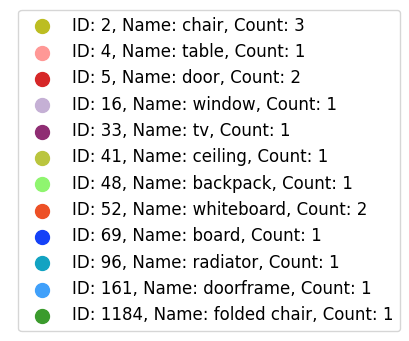

In [4]:
#
# Get the legend for objects in the scene
#

plt.figure(figsize=(0.001, len(objects) * 0.2))

# Loop over the objects and add them to the plot
for i, obj in enumerate(objects):
    object_ID = obj[0]
    count = obj[1]
    label = obj[2]
    color = [c/255 for c in obj[3]]  # normalize the color values

    plt.scatter([], [], c=[color], label=f'ID: {object_ID}, Name: {label}, Count: {count}', s=100)
    
# Create a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
plt.axis('off')
plt.show()

In [5]:
# Show the segmentation with Mask3D (computed by LabelMaker)
pcd_mask3D = o3d.io.read_point_cloud(os.path.join(base_path, "mesh_labelled.ply")) # TODO TOSET: change the name of the point cloud to open
o3d.visualization.draw_geometries([pcd_mask3D])

To get the point cloud with the labels of the classes:

In [28]:
from open3d.t.geometry import TriangleMesh

hello_open3d_mesh:TriangleMesh = o3d.t.geometry.TriangleMesh.create_text("Ciao", depth=0.1).to_legacy()
hello_open3d_mesh.paint_uniform_color((0, 0, 0))


# Scale down since default mesh is quite big
# Location
location = (0, 0, 0)  # The mesh is not centered at origin, so there is already an offset.
# I am adding another location shift as an example.
hello_open3d_mesh.transform([[0.1, 0, 0, location[0]], [0, 0.1, 0, location[1]], [0, 0, 0.1, location[2]],
                             [0, 0, 0, 1]])
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])

o3d.visualization.draw_geometries([origin, hello_open3d_mesh], mesh_show_back_face=True)